In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import geopy
from geopy.geocoders import Nominatim
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


In [2]:
# pull in data sourced and cleaned by Madina with US state, county, elevation added by Chris
meteor_data = pd.read_csv('Resources/Meteorite_US_county_elev.csv')

In [3]:
meteor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650 entries, 0 to 1649
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         1650 non-null   object 
 1   id           1650 non-null   int64  
 2   nametype     1650 non-null   object 
 3   recclass     1650 non-null   object 
 4   mass (g)     1650 non-null   float64
 5   fall         1650 non-null   object 
 6   year         1650 non-null   int64  
 7   reclat       1650 non-null   float64
 8   reclong      1650 non-null   float64
 9   GeoLocation  1650 non-null   object 
 10  county       1598 non-null   object 
 11  state        1650 non-null   object 
 12  country      1650 non-null   object 
 13  elevation    1650 non-null   int64  
dtypes: float64(3), int64(3), object(8)
memory usage: 180.6+ KB


In [4]:
meteor_data.describe()

,id,mass (g),year,reclat,reclong,elevation
count,1650.000000,1.650000e+03,1650.000000,1650.000000,1650.000000,1650.000000
mean,20378.932121,5.493077e+04,1956.793939,36.396478,-102.977600,846.032727
std,13860.928289,8.464998e+05,43.348755,3.774957,11.347882,529.185581
min,5.000000,5.000000e-01,1807.000000,21.300000,-163.166670,-20.000000
25%,10908.250000,9.001000e+01,1935.000000,34.091670,-113.295003,402.000000
50%,18064.500000,1.705000e+03,1967.000000,35.284305,-102.775000,843.000000
75%,24066.750000,1.040000e+04,1998.000000,38.814447,-97.964585,1233.000000
max,57455.000000,3.000000e+07,2012.000000,65.383330,-68.750000,3841.000000


In [5]:
meteor_data.head()

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation,county,state,country,elevation
0,Allegan,2276,Valid,H5,32000.0,Fell,1899,42.53333,-85.88333,"(42.53333, -85.88333)",Allegan County,Michigan,United States,225
1,Andover,2295,Valid,L6,3200.0,Fell,1898,44.61667,-70.75000,"(44.61667, -70.75)",Oxford County,Maine,United States,220
2,Archie,2329,Valid,H6,5070.0,Fell,1932,38.50000,-94.30000,"(38.5, -94.3)",Cass County,Missouri,United States,264
3,Ash Creek,48954,Valid,L6,9500.0,Fell,2009,31.80500,-97.01000,"(31.805, -97.01)",McLennan County,Texas,United States,170
4,Athens,4885,Valid,LL6,265.0,Fell,1933,34.75000,-87.00000,"(34.75, -87.0)",Limestone County,Alabama,United States,204


In [6]:
# Dropping null values
meteor_data=meteor_data.dropna().copy()

In [7]:
# Checking missing values. 
meteor_data.isnull().sum()

name           0
id             0
nametype       0
recclass       0
mass (g)       0
fall           0
year           0
reclat         0
reclong        0
GeoLocation    0
county         0
state          0
country        0
elevation      0
dtype: int64

In [8]:
# Find max year
print(meteor_data["year"].max())
meteor_data['year']=meteor_data["year"].astype(int)

2012


In [9]:
meteor_data.head(2)

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation,county,state,country,elevation
0,Allegan,2276,Valid,H5,32000.0,Fell,1899,42.53333,-85.88333,"(42.53333, -85.88333)",Allegan County,Michigan,United States,225
1,Andover,2295,Valid,L6,3200.0,Fell,1898,44.61667,-70.75000,"(44.61667, -70.75)",Oxford County,Maine,United States,220


In [10]:
# Getting Valids from nametype for map
valids = meteor_data.groupby('nametype').get_group('Valid').copy()
valids.dropna(inplace=True)
valids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1598 entries, 0 to 1649
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         1598 non-null   object 
 1   id           1598 non-null   int64  
 2   nametype     1598 non-null   object 
 3   recclass     1598 non-null   object 
 4   mass (g)     1598 non-null   float64
 5   fall         1598 non-null   object 
 6   year         1598 non-null   int32  
 7   reclat       1598 non-null   float64
 8   reclong      1598 non-null   float64
 9   GeoLocation  1598 non-null   object 
 10  county       1598 non-null   object 
 11  state        1598 non-null   object 
 12  country      1598 non-null   object 
 13  elevation    1598 non-null   int64  
dtypes: float64(3), int32(1), int64(2), object(8)
memory usage: 181.0+ KB


In [11]:
# Create a scatter map using the 'reclat' and 'reclong' columns of the dataframe as latitude and longitude, respectively
fig = px.scatter_mapbox(meteor_data, lat="reclat", lon="reclong")

# customize the layout of the Map
fig.update_layout(
    mapbox_style="open-street-map",
    mapbox=dict(center=dict(lat=0, lon=0), zoom=0),
    margin=dict(l=0, r=0, t=0, b=0),
    width=600, height=600
)

# Display the map
fig.show()

In [12]:
meteor_data['fall'].value_counts()

Found    1454
Fell      144
Name: fall, dtype: int64

In [13]:
lcounty = meteor_data['county'].to_list()
print(len(lcounty))
lcounty

1598


['Allegan County',
 'Oxford County',
 'Cass County',
 'McLennan County',
 'Limestone County',
 'Atoka County',
 'San Juan County',
 'Yancey County',
 'Lee County',
 'Brown County',
 'Bath County',
 'Humboldt County',
 'Stone County',
 'Rawlins County',
 'Grayson County',
 'Fayette County',
 'Weld County',
 'Albany County',
 'Lee County',
 'Centre County',
 'Kay County',
 'Brown County',
 'McLean County',
 'Allegheny County',
 'Pike County',
 'Johnson County',
 'Fremont County',
 'Cape Girardeau County',
 'Nash County',
 'Hancock County',
 'Caswell County',
 'Lincoln County',
 'Dickson County',
 'Spartanburg County',
 'Butler County',
 'Evans County',
 'Marathon County',
 'Midland County',
 'Logan County',
 'Wilson County',
 'McCreary County',
 'Harrison County',
 'Morgan County',
 'Monmouth County',
 'Sumner County',
 'Lancaster County',
 'Elbert County',
 'Emmet County',
 'Washington County',
 'Pitt County',
 'Washington County',
 'Perry County',
 'Wilkes County',
 'Polk County',
 'Wi

In [14]:
# pull in land cover data sourced and cleaned by Greg, additional data manipulation by Chris
land_data = pd.read_csv('Resources/LAND_COVER_14032023014858227.csv')

In [15]:
land_data.head(2)

,COU,Country,SMALL_SUBNATIONAL_REGION,Small subnational region,LARGE_SUBNATIONAL_REGION,Large subnational region,MEAS,Measure,VARIABLE,Land cover class,...,Year,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,NaN,Not applicable,GAUL1_467_2015,Administrative unit not available,THOUSAND_SQKM,Square kilometers (000's),CROPL,Cropland,...,1992,KM2,Square kilometres,3,Thousands,NaN,NaN,0.0,NaN,NaN
1,AUS,Australia,NaN,Not applicable,GAUL1_467_2015,Administrative unit not available,THOUSAND_SQKM,Square kilometers (000's),CROPL,Cropland,...,2004,KM2,Square kilometres,3,Thousands,NaN,NaN,0.0,NaN,NaN


In [16]:
# Filtering to USA - Greg
usa_data = land_data.loc[land_data['COU'] == 'USA'] 
print(len(usa_data))
usa_data.head(2)


4590


,COU,Country,SMALL_SUBNATIONAL_REGION,Small subnational region,LARGE_SUBNATIONAL_REGION,Large subnational region,MEAS,Measure,VARIABLE,Land cover class,...,Year,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
220473,USA,United States,NaN,Not applicable,OECD_US01_2021,Alabama,THOUSAND_SQKM,Square kilometers (000's),FOREST,Tree cover,...,1992,KM2,Square kilometres,3,Thousands,NaN,NaN,91.541198,NaN,NaN
220474,USA,United States,NaN,Not applicable,OECD_US01_2021,Alabama,THOUSAND_SQKM,Square kilometers (000's),FOREST,Tree cover,...,2004,KM2,Square kilometres,3,Thousands,NaN,NaN,91.354866,NaN,NaN


In [17]:
# Filtering to most recent year - Greg
usa_2019_data_start = usa_data.loc[usa_data['Year'] == 2019].copy()
print(len(usa_2019_data_start))
usa_2019_data_start.head(2)

918


,COU,Country,SMALL_SUBNATIONAL_REGION,Small subnational region,LARGE_SUBNATIONAL_REGION,Large subnational region,MEAS,Measure,VARIABLE,Land cover class,...,Year,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
220477,USA,United States,NaN,Not applicable,OECD_US01_2021,Alabama,THOUSAND_SQKM,Square kilometers (000's),FOREST,Tree cover,...,2019,KM2,Square kilometres,3,Thousands,NaN,NaN,87.106024,NaN,NaN
220482,USA,United States,NaN,Not applicable,OECD_US01_2021,Alabama,THOUSAND_SQKM,Square kilometers (000's),GRSL,Grassland,...,2019,KM2,Square kilometres,3,Thousands,NaN,NaN,26.726430,NaN,NaN


In [18]:
# rename region column to state
usa_2019_data_start.rename({'Large subnational region':'state'},axis=1, inplace = True)
print(len(usa_2019_data_start))
print(type(usa_2019_data_start))
usa_2019_data_start.head(2)

918
<class 'pandas.core.frame.DataFrame'>


,COU,Country,SMALL_SUBNATIONAL_REGION,Small subnational region,LARGE_SUBNATIONAL_REGION,state,MEAS,Measure,VARIABLE,Land cover class,...,Year,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
220477,USA,United States,NaN,Not applicable,OECD_US01_2021,Alabama,THOUSAND_SQKM,Square kilometers (000's),FOREST,Tree cover,...,2019,KM2,Square kilometres,3,Thousands,NaN,NaN,87.106024,NaN,NaN
220482,USA,United States,NaN,Not applicable,OECD_US01_2021,Alabama,THOUSAND_SQKM,Square kilometers (000's),GRSL,Grassland,...,2019,KM2,Square kilometres,3,Thousands,NaN,NaN,26.726430,NaN,NaN


In [19]:
# replace district of columbia to help with merges
usa_2019_data_start.replace({'District Of Columbia':'District of Columbia'}, inplace = True)
print(len(usa_2019_data_start))
print(type(usa_2019_data_start))
usa_2019_data_start.head(2)

918
<class 'pandas.core.frame.DataFrame'>


,COU,Country,SMALL_SUBNATIONAL_REGION,Small subnational region,LARGE_SUBNATIONAL_REGION,state,MEAS,Measure,VARIABLE,Land cover class,...,Year,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
220477,USA,United States,NaN,Not applicable,OECD_US01_2021,Alabama,THOUSAND_SQKM,Square kilometers (000's),FOREST,Tree cover,...,2019,KM2,Square kilometres,3,Thousands,NaN,NaN,87.106024,NaN,NaN
220482,USA,United States,NaN,Not applicable,OECD_US01_2021,Alabama,THOUSAND_SQKM,Square kilometers (000's),GRSL,Grassland,...,2019,KM2,Square kilometres,3,Thousands,NaN,NaN,26.726430,NaN,NaN


In [20]:
# get number of states in land cover data (usa_2019_data_start)
print(len(usa_2019_data_start['state'].unique()))
usa_2019_data_start['state'].unique()

51


array(['Alabama', 'Colorado', 'Connecticut', 'Georgia', 'Illinois',
       'Indiana', 'Iowa', 'Kentucky', 'Maine', 'Maryland', 'Delaware',
       'Wyoming', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Florida', 'Hawaii', 'Idaho', 'Kansas', 'New Mexico',
       'North Dakota', 'Oklahoma', 'District of Columbia',
       'Massachusetts', 'Michigan', 'Minnesota', 'Montana', 'Nebraska',
       'New Hampshire', 'New Jersey', 'New York', 'North Carolina',
       'Ohio', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'Texas',
       'Utah', 'Vermont', 'Washington', 'Louisiana', 'Mississippi',
       'Missouri', 'Nevada', 'Oregon', 'South Dakota', 'Tennessee',
       'West Virginia', 'Wisconsin', 'Virginia'], dtype=object)

In [21]:
# read in state FIPS info from csv
state_fips = pd.read_csv('Resources/state_fips.csv')
state_fips.head()

,state,state_abbrev,FIPS
0,Alabama,AL,1
1,Alaska,AK,2
2,Arizona,AZ,4
3,Arkansas,AR,5
4,California,CA,6


In [22]:
# get number of states in fips data  https://www.bls.gov/respondents/mwr/electronic-data-interchange/appendix-d-usps-state-abbreviations-and-fips-codes.htm
len(state_fips['state'].unique())

53

In [23]:
#  read in state area info from csv  https://www.census.gov/geographies/reference-files/2010/geo/state-area.html
state_areas = pd.read_csv('Resources/state_sqkm.csv')
state_areas.head()

,state,Area(sq.km)
0,Alabama,135767
1,Alaska,1723337
2,Arizona,295234
3,Arkansas,137732
4,California,423967


In [24]:
state_areas.dtypes

state          object
Area(sq.km)     int64
dtype: object

In [25]:
# merge land cover data with state fips data
usa_2019_data_interim1 = pd.merge(usa_2019_data_start,state_fips)
print(len(usa_2019_data_interim1))
usa_2019_data_interim1.head(2)

918


,COU,Country,SMALL_SUBNATIONAL_REGION,Small subnational region,LARGE_SUBNATIONAL_REGION,state,MEAS,Measure,VARIABLE,Land cover class,...,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags,state_abbrev,FIPS
0,USA,United States,NaN,Not applicable,OECD_US01_2021,Alabama,THOUSAND_SQKM,Square kilometers (000's),FOREST,Tree cover,...,Square kilometres,3,Thousands,NaN,NaN,87.106024,NaN,NaN,AL,1
1,USA,United States,NaN,Not applicable,OECD_US01_2021,Alabama,THOUSAND_SQKM,Square kilometers (000's),GRSL,Grassland,...,Square kilometres,3,Thousands,NaN,NaN,26.726430,NaN,NaN,AL,1


In [26]:
# merge land cover fips data with state area data
usa_2019_data_interim2 = pd.merge(usa_2019_data_interim1,state_areas)
print(len(usa_2019_data_interim2))
usa_2019_data_interim2.head(2)

918


,COU,Country,SMALL_SUBNATIONAL_REGION,Small subnational region,LARGE_SUBNATIONAL_REGION,state,MEAS,Measure,VARIABLE,Land cover class,...,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags,state_abbrev,FIPS,Area(sq.km)
0,USA,United States,NaN,Not applicable,OECD_US01_2021,Alabama,THOUSAND_SQKM,Square kilometers (000's),FOREST,Tree cover,...,3,Thousands,NaN,NaN,87.106024,NaN,NaN,AL,1,135767
1,USA,United States,NaN,Not applicable,OECD_US01_2021,Alabama,THOUSAND_SQKM,Square kilometers (000's),GRSL,Grassland,...,3,Thousands,NaN,NaN,26.726430,NaN,NaN,AL,1,135767


In [27]:
# for Chris evaluation - reduce land cover fips area dataset to measurements by percent (rather than by square kilometers)
usa_2019_data = usa_2019_data_interim2.loc[usa_2019_data_interim2['MEAS'] == 'PCNT'] 
print(len(usa_2019_data))
usa_2019_data.head(2)

459


,COU,Country,SMALL_SUBNATIONAL_REGION,Small subnational region,LARGE_SUBNATIONAL_REGION,state,MEAS,Measure,VARIABLE,Land cover class,...,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags,state_abbrev,FIPS,Area(sq.km)
9,USA,United States,NaN,Not applicable,OECD_US01_2021,Alabama,PCNT,Percent of total country area,FOREST,Tree cover,...,0,Units,NaN,NaN,64.872148,NaN,NaN,AL,1,135767
10,USA,United States,NaN,Not applicable,OECD_US01_2021,Alabama,PCNT,Percent of total country area,GRSL,Grassland,...,0,Units,NaN,NaN,19.904490,NaN,NaN,AL,1,135767


In [28]:
#creating new DF with needed rows 
usa_2019_data =usa_2019_data[[
       'COU','Country','state', 'Measure', 'VARIABLE',
       'Land cover class', 'Unit', 'Value', 'state_abbrev', 'FIPS','Area(sq.km)'
       ]]
print(len(usa_2019_data))
usa_2019_data.head(2)

459


,COU,Country,state,Measure,VARIABLE,Land cover class,Unit,Value,state_abbrev,FIPS,Area(sq.km)
9,USA,United States,Alabama,Percent of total country area,FOREST,Tree cover,Percentage,64.872148,AL,1,135767
10,USA,United States,Alabama,Percent of total country area,GRSL,Grassland,Percentage,19.904490,AL,1,135767


In [29]:
usa_2019_data.dtypes

COU                  object
Country              object
state                object
Measure              object
VARIABLE             object
Land cover class     object
Unit                 object
Value               float64
state_abbrev         object
FIPS                  int64
Area(sq.km)           int64
dtype: object

In [30]:
# Checking missing values. 
usa_2019_data.isnull().sum()

COU                 0
Country             0
state               0
Measure             0
VARIABLE            0
Land cover class    0
Unit                0
Value               0
state_abbrev        0
FIPS                0
Area(sq.km)         0
dtype: int64

In [31]:
# checking number of unique values per column
usa_2019_data.nunique()

COU                   1
Country               1
state                51
Measure               1
VARIABLE              9
Land cover class      9
Unit                  1
Value               457
state_abbrev         51
FIPS                 51
Area(sq.km)          51
dtype: int64

In [32]:
statesum = usa_2019_data.groupby(['state', 'Land cover class']).sum()
statesum

Value  FIPS  Area(sq.km)
state   Land cover class                                 
Alabama Artificial surfaces   1.659720     1       135767
        Bare area             0.189766     1       135767
        Cropland             10.177265     1       135767
        Grassland            19.904490     1       135767
        Inland water          1.762286     1       135767
...                                ...   ...          ...
Wyoming Inland water          0.546852    56       253335
        Shrubland            48.549833    56       253335
        Sparse vegetation     0.128868    56       253335
        Tree cover           18.860932    56       253335
        Wetland               0.439269    56       253335

[459 rows x 3 columns]

In [33]:
#  check dataframe
usa_2019_data.head(2)

,COU,Country,state,Measure,VARIABLE,Land cover class,Unit,Value,state_abbrev,FIPS,Area(sq.km)
9,USA,United States,Alabama,Percent of total country area,FOREST,Tree cover,Percentage,64.872148,AL,1,135767
10,USA,United States,Alabama,Percent of total country area,GRSL,Grassland,Percentage,19.904490,AL,1,135767


In [34]:
usa_2019_data_lc = usa_2019_data[['state','VARIABLE','Value']].copy()
usa_2019_data_lc.set_index('state',inplace=True)
usa_2019_data_lc 

,VARIABLE,Value
state,,
Alabama,FOREST,64.872148
Alabama,GRSL,19.904490
Alabama,WETL,0.176988
Alabama,SHRUBL,1.222573
Alabama,SPARSE_VEGETATION,0.034765
...,...,...
Virginia,SPARSE_VEGETATION,0.025975
Virginia,CROPL,10.927344
Virginia,URBAN,2.967337


In [35]:
# set state as index for pivot table (next step)
usa_2019_data_fipsarea = usa_2019_data[['state','state_abbrev','Unit','FIPS','Area(sq.km)']].copy()
usa_2019_data_fipsarea.drop_duplicates(inplace = True)
usa_2019_data_fipsarea.set_index('state',inplace=True)
usa_2019_data_fipsarea 


,state_abbrev,Unit,FIPS,Area(sq.km)
state,,,,
Alabama,AL,Percentage,1,135767
Colorado,CO,Percentage,8,269601
Connecticut,CT,Percentage,9,14357
Georgia,GA,Percentage,13,153910
Illinois,IL,Percentage,17,149995
Indiana,IN,Percentage,18,94326
Iowa,IA,Percentage,19,145746
Kentucky,KY,Percentage,21,104656
Maine,ME,Percentage,23,91633


In [36]:
# pivot table to create columns for each variable
landcovery = (usa_2019_data_lc.pivot_table(index = usa_2019_data_lc.index, columns='VARIABLE',values = 'Value', aggfunc=lambda x: x, fill_value=0)
       .rename_axis(None, axis='columns')
      
)
print(len(landcovery))
landcovery.head(2)

51


,BARE,CROPL,FOREST,GRSL,SHRUBL,SPARSE_VEGETATION,URBAN,WATER,WETL
state,,,,,,,,,
Alabama,0.189766,10.177265,64.872148,19.904490,1.222573,0.034765,1.659720,1.762286,0.176988
Alaska,10.875705,0.045602,34.319849,10.628187,20.993753,15.991683,0.014371,5.340909,1.789941


In [37]:
# merge state fips area info with pivoted land cover data
landcoverier = pd.merge(usa_2019_data_fipsarea,landcovery, on = 'state')
print(len(landcoverier))
landcoverier.head(2)

51


,state_abbrev,Unit,FIPS,Area(sq.km),BARE,CROPL,FOREST,GRSL,SHRUBL,SPARSE_VEGETATION,URBAN,WATER,WETL
state,,,,,,,,,,,,,
Alabama,AL,Percentage,1,135767,0.189766,10.177265,64.872148,19.904490,1.222573,0.034765,1.659720,1.762286,0.176988
Colorado,CO,Percentage,8,269601,1.342844,15.531944,32.930439,31.771219,17.246873,0.035923,0.846416,0.257818,0.036524


In [38]:
landcoverier.dtypes

state_abbrev          object
Unit                  object
FIPS                   int64
Area(sq.km)            int64
BARE                 float64
CROPL                float64
FOREST               float64
GRSL                 float64
SHRUBL               float64
SPARSE_VEGETATION    float64
URBAN                float64
WATER                float64
WETL                 float64
dtype: object

In [39]:
# reset state from index to column
landcoveriest = landcoverier.reset_index()
print(len(landcoveriest))
landcoveriest.head(2)

51


,state,state_abbrev,Unit,FIPS,Area(sq.km),BARE,CROPL,FOREST,GRSL,SHRUBL,SPARSE_VEGETATION,URBAN,WATER,WETL
0,Alabama,AL,Percentage,1,135767,0.189766,10.177265,64.872148,19.904490,1.222573,0.034765,1.659720,1.762286,0.176988
1,Colorado,CO,Percentage,8,269601,1.342844,15.531944,32.930439,31.771219,17.246873,0.035923,0.846416,0.257818,0.036524


In [40]:
# check meteor dataframe
meteor_data.head(2)

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation,county,state,country,elevation
0,Allegan,2276,Valid,H5,32000.0,Fell,1899,42.53333,-85.88333,"(42.53333, -85.88333)",Allegan County,Michigan,United States,225
1,Andover,2295,Valid,L6,3200.0,Fell,1898,44.61667,-70.75000,"(44.61667, -70.75)",Oxford County,Maine,United States,220


In [41]:
# create list of states in the meteor dataframe
lstateMeteor = list(meteor_data['state'].unique())
print(len(lstateMeteor))
lstateMeteor

46


['Michigan',
 'Maine',
 'Missouri',
 'Texas',
 'Alabama',
 'Oklahoma',
 'New Mexico',
 'North Carolina',
 'Mississippi',
 'South Dakota',
 'Kentucky',
 'Nevada',
 'Kansas',
 'Illinois',
 'Colorado',
 'New York',
 'South Carolina',
 'Pennsylvania',
 'Arkansas',
 'Tennessee',
 'Georgia',
 'Wisconsin',
 'New Jersey',
 'Nebraska',
 'Iowa',
 'Minnesota',
 'Virginia',
 'Utah',
 'Indiana',
 'Arizona',
 'Hawaii',
 'Maryland',
 'Ohio',
 'Louisiana',
 'Florida',
 'California',
 'North Dakota',
 'Oregon',
 'Connecticut',
 'Wyoming',
 'Washington',
 'Alaska',
 'West Virginia',
 'Montana',
 'Idaho',
 'Massachusetts']

In [42]:
# create list of states from land cover fips area dataframe
lstateLand = landcoveriest['state'].to_list()
print(len(lstateLand))
lstateLand

51


['Alabama',
 'Colorado',
 'Connecticut',
 'Georgia',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kentucky',
 'Maine',
 'Maryland',
 'Delaware',
 'Wyoming',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Florida',
 'Hawaii',
 'Idaho',
 'Kansas',
 'New Mexico',
 'North Dakota',
 'Oklahoma',
 'District of Columbia',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Montana',
 'Nebraska',
 'New Hampshire',
 'New Jersey',
 'New York',
 'North Carolina',
 'Ohio',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'Texas',
 'Utah',
 'Vermont',
 'Washington',
 'Louisiana',
 'Mississippi',
 'Missouri',
 'Nevada',
 'Oregon',
 'South Dakota',
 'Tennessee',
 'West Virginia',
 'Wisconsin',
 'Virginia']

In [43]:
#  check to see which states have not had a meteorite find recorded
list(set(lstateLand)-set(lstateMeteor))

['Delaware',
 'District of Columbia',
 'Vermont',
 'New Hampshire',
 'Rhode Island']

In [44]:
# check length of meteor dataframe to verify no rows lost during merge at next step
print(len(meteor_data))

1598


In [45]:
# merge meteor dataframe and land cover fips area dataframe
ultimate_df = pd.merge(meteor_data,landcoveriest)
print(len(ultimate_df))
ultimate_df.head(2)

1598


,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation,...,Area(sq.km),BARE,CROPL,FOREST,GRSL,SHRUBL,SPARSE_VEGETATION,URBAN,WATER,WETL
0,Allegan,2276,Valid,H5,32000.0,Fell,1899,42.53333,-85.88333,"(42.53333, -85.88333)",...,250487,0.241572,35.820019,52.486729,4.448891,0.668927,0.026182,3.350872,2.644462,0.312346
1,Coleman,5401,Valid,L6,469.0,Fell,1994,43.76111,-84.50778,"(43.76111, -84.50778)",...,250487,0.241572,35.820019,52.486729,4.448891,0.668927,0.026182,3.350872,2.644462,0.312346


In [46]:
ultimate_df.columns

Index(['name', 'id', 'nametype', 'recclass', 'mass (g)', 'fall', 'year',
       'reclat', 'reclong', 'GeoLocation', 'county', 'state', 'country',
       'elevation', 'state_abbrev', 'Unit', 'FIPS', 'Area(sq.km)', 'BARE',
       'CROPL', 'FOREST', 'GRSL', 'SHRUBL', 'SPARSE_VEGETATION', 'URBAN',
       'WATER', 'WETL'],
      dtype='object')

In [47]:
# drop columns for machine learning (state to be identified by FIPS code)
ultimate_df.drop(columns=['name','id','nametype','county','state','state_abbrev','Unit','country','GeoLocation'],axis = 1, inplace=True)

In [48]:
ultimate_df.head(2)

,recclass,mass (g),fall,year,reclat,reclong,elevation,FIPS,Area(sq.km),BARE,CROPL,FOREST,GRSL,SHRUBL,SPARSE_VEGETATION,URBAN,WATER,WETL
0,H5,32000.0,Fell,1899,42.53333,-85.88333,225,26,250487,0.241572,35.820019,52.486729,4.448891,0.668927,0.026182,3.350872,2.644462,0.312346
1,L6,469.0,Fell,1994,43.76111,-84.50778,218,26,250487,0.241572,35.820019,52.486729,4.448891,0.668927,0.026182,3.350872,2.644462,0.312346


In [49]:
print(ultimate_df['fall'].unique())
ultimate_df.replace(['Fell',"Found"],[0,1],inplace = True)

['Fell' 'Found']


In [50]:
print(len(ultimate_df))
ultimate_df.head(2)

1598


,recclass,mass (g),fall,year,reclat,reclong,elevation,FIPS,Area(sq.km),BARE,CROPL,FOREST,GRSL,SHRUBL,SPARSE_VEGETATION,URBAN,WATER,WETL
0,H5,32000.0,0,1899,42.53333,-85.88333,225,26,250487,0.241572,35.820019,52.486729,4.448891,0.668927,0.026182,3.350872,2.644462,0.312346
1,L6,469.0,0,1994,43.76111,-84.50778,218,26,250487,0.241572,35.820019,52.486729,4.448891,0.668927,0.026182,3.350872,2.644462,0.312346


Standardize meteorite recclass 
https://www.mindat.org/min-49514.html
https://www.lpi.usra.edu/meteor/metbullclass.php?sea=OC 
https://en.wikipedia.org/wiki/Meteorite_classification


In [51]:
meteor_types = pd.read_csv('Resources/meteorite_types.csv')
print(len(meteor_types))
meteor_types

122


,recclass,Meteorite_Class,Meteorite_Type
0,H5,Chrondrite - ordinary,Chrondrite
1,L6,Chrondrite - ordinary,Chrondrite
2,L5,Chrondrite - ordinary,Chrondrite
3,"Iron, ungrouped",Iron - other,Iron
4,"Iron, IVA",Iron - magmatic,Iron
...,...,...,...
117,H5-6,Chrondrite - ordinary,Chrondrite
118,LL3,Chrondrite - ordinary,Chrondrite
119,CK4,Chrondrite - carbonaceous,Chrondrite
120,CK5,Chrondrite - carbonaceous,Chrondrite


In [52]:
meteor_types['Meteorite_Class'].value_counts()

Chrondrite - ordinary        55
Chrondrite - carbonaceous    14
Iron - magmatic              12
Achrondrite                  10
Iron - primitive              9
Mesosiderite                  6
Pallasite                     5
Iron - other                  4
Chrondrite - enstatite        3
Achrondrites - asteroidal     1
Achondrites - primitive       1
Achrondrite - other           1
Chrondrite - other            1
Name: Meteorite_Class, dtype: int64

In [53]:
meteor_types.replace({'Chrondrite - ordinary':'Chrondrite','Chrondrite - carbonaceous':'Chrondrite','Chrondrite - other':'Chrondrite','Iron - magmatic':'Iron','Iron - primitive':'Iron','Iron - other':'Iron','Achondrites - primitive':'Achrondrite','Achrondrite - other':'Achrondrite','Achrondrites - asteroidal':'Achrondrite','Chrondrite - enstatite': 'Chrondrite'}, inplace = True)
# replace district of columbia to help with merges
# usa_2019_data_start.replace({'District Of Columbia':'District of Columbia'}, inplace = True)
print(len(meteor_types))
print(type(meteor_types))
meteor_types['Meteorite_Class'].value_counts()

122
<class 'pandas.core.frame.DataFrame'>


Chrondrite      73
Iron            25
Achrondrite     13
Mesosiderite     6
Pallasite        5
Name: Meteorite_Class, dtype: int64

In [54]:
mtypes = list(ultimate_df['recclass'].unique())
print(len(mtypes))
mtypes

123


['H5',
 'L6',
 'L5',
 'Iron, ungrouped',
 'Iron, IVA',
 'Iron, IIIAB',
 'Eucrite-pmict',
 'OC',
 'H6',
 'L3',
 'CO3.7',
 'Pallasite, PMG-an',
 'H',
 'Iron, IAB-MG',
 'Pallasite, ungrouped',
 'Mesosiderite-B4',
 'Iron, IIC',
 'Iron, IC',
 'Iron, IIIF',
 'C2-ung',
 'H3',
 'L4',
 'Eucrite-mmict',
 'Aubrite',
 'H4',
 'CV3',
 'H4/5',
 'H3.7',
 'Iron, IID',
 'Iron, IAB-ung',
 'H?',
 'Iron, IAB-sLM',
 'Iron, IIAB',
 'Iron, IAB-sLL',
 'Iron, IIF',
 'Iron, IVB',
 'LL4',
 'Iron',
 'EL6/7',
 'CK3',
 'L',
 'LL5',
 'Acapulcoite',
 'H4/6',
 'H3.5',
 'Iron, IIIE',
 'Iron, IAB complex',
 'LL6',
 'L6/7',
 'H3.9',
 'Pallasite, PMG',
 'H3-6',
 'Winonaite',
 'H3-4',
 'LL3.3',
 'CO3.3',
 'Howardite',
 'Iron, IIG',
 'Iron, IAB-an',
 'CM2',
 'CO3.0',
 'L3.5-5',
 'H3.4',
 'LL3.1',
 'CBa',
 'H3.6',
 'L3-6',
 'L5-7',
 'Ureilite',
 'K3',
 'LL3.4',
 'H3.8',
 'H3.10',
 'L/LL5',
 'H(5?)',
 'Iron, IIE',
 'Eucrite-cm',
 'Iron, IAB-sHH',
 'EL6',
 'Mesosiderite-A3',
 'H4-an',
 'L/LL4',
 'Pallasite, PES',
 'R3-6',
 'CM1

In [55]:
ultimate_df2 = pd.merge(ultimate_df,meteor_types, how='outer')
print(len(ultimate_df2))
ultimate_df2

1598


,recclass,mass (g),fall,year,reclat,reclong,elevation,FIPS,Area(sq.km),BARE,CROPL,FOREST,GRSL,SHRUBL,SPARSE_VEGETATION,URBAN,WATER,WETL,Meteorite_Class,Meteorite_Type
0,H5,32000.0,0,1899,42.53333,-85.88333,225,26,250487,0.241572,35.820019,52.486729,4.448891,0.668927,0.026182,3.350872,2.644462,0.312346,Chrondrite,Chrondrite
1,H5,10600.0,0,1921,44.51667,-83.95000,387,26,250487,0.241572,35.820019,52.486729,4.448891,0.668927,0.026182,3.350872,2.644462,0.312346,Chrondrite,Chrondrite
2,H5,5400.0,0,1871,44.36667,-69.20000,76,23,91633,0.073362,3.781799,87.034079,2.000897,0.063259,0.022664,0.835475,6.033821,0.154643,Chrondrite,Chrondrite
3,H5,100000.0,1,1966,39.61667,-94.86667,329,29,180540,0.055780,39.169822,28.910780,28.997891,0.019235,0.012908,1.492084,1.049221,0.292279,Chrondrite,Chrondrite
4,H5,2587.0,0,1998,31.60833,-102.85833,812,48,695662,0.321731,22.484104,12.810792,27.968962,32.543054,0.037720,2.167126,1.131689,0.534823,Chrondrite,Chrondrite
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1593,CK5,3.5,1,2008,34.48712,-116.96147,869,6,423967,4.696131,13.344960,29.658273,12.065105,34.547941,0.129056,3.942515,1.393910,0.222108,Chrondrite,Chrondrite
1594,CK5,1.1,1,2008,34.48657,-116.95920,869,6,423967,4.696131,13.344960,29.658273,12.065105,34.547941,0.129056,3.942515,1.393910,0.222108,Chrondrite,Chrondrite
1595,CK5,3.2,1,2008,34.48733,-116.96055,869,6,423967,4.696131,13.344960,29.658273,12.065105,34.547941,0.129056,3.942515,1.393910,0.222108,Chrondrite,Chrondrite
1596,CK5,0.8,1,2008,34.48738,-116.96065,869,6,423967,4.696131,13.344960,29.658273,12.065105,34.547941,0.129056,3.942515,1.393910,0.222108,Chrondrite,Chrondrite


In [56]:
ultimate_df2.dtypes

recclass              object
mass (g)             float64
fall                   int64
year                   int32
reclat               float64
reclong              float64
elevation              int64
FIPS                   int64
Area(sq.km)            int64
BARE                 float64
CROPL                float64
FOREST               float64
GRSL                 float64
SHRUBL               float64
SPARSE_VEGETATION    float64
URBAN                float64
WATER                float64
WETL                 float64
Meteorite_Class       object
Meteorite_Type        object
dtype: object

In [57]:
dummies = pd.get_dummies(ultimate_df2['Meteorite_Class'])
merged = pd.concat([ultimate_df2,dummies], axis='columns')
merged.drop(['Meteorite_Class','recclass','Meteorite_Type'],axis='columns', inplace = True)

In [58]:
merged.dtypes

mass (g)             float64
fall                   int64
year                   int32
reclat               float64
reclong              float64
elevation              int64
FIPS                   int64
Area(sq.km)            int64
BARE                 float64
CROPL                float64
FOREST               float64
GRSL                 float64
SHRUBL               float64
SPARSE_VEGETATION    float64
URBAN                float64
WATER                float64
WETL                 float64
Achrondrite            uint8
Chrondrite             uint8
Iron                   uint8
Mesosiderite           uint8
Pallasite              uint8
dtype: object

In [59]:
# write US meteorite data into csv file
merged.to_csv('Resources/Meteorite_US_all.csv')

In [60]:
collist = merged.columns.to_list()

In [61]:
# try to force all cols to numeric  from Mod19-Day03-Act-05
for col in merged.columns:
    if merged[col].dtype == 'object':
        merged[col] = pd.to_numeric(merged[col], errors='coerce')

In [62]:
# # set x and y
# Xa = merged.drop('state', axis=1)
# ya = merged['state']
# print(len(Xa))
# print(type(Xa))
# print(Xa)


In [63]:
# print(len(ya))
# print(type(ya))
# print(ya)

In [64]:
# set x and y
X = merged.drop('fall', axis=1)
y = merged['fall']
print(len(X))
print(type(X))
print(X)


1598
<class 'pandas.core.frame.DataFrame'>
      mass (g)  year    reclat    reclong  elevation  FIPS  Area(sq.km)  \
0      32000.0  1899  42.53333  -85.88333        225    26       250487   
1      10600.0  1921  44.51667  -83.95000        387    26       250487   
2       5400.0  1871  44.36667  -69.20000         76    23        91633   
3     100000.0  1966  39.61667  -94.86667        329    29       180540   
4       2587.0  1998  31.60833 -102.85833        812    48       695662   
...        ...   ...       ...        ...        ...   ...          ...   
1593       3.5  2008  34.48712 -116.96147        869     6       423967   
1594       1.1  2008  34.48657 -116.95920        869     6       423967   
1595       3.2  2008  34.48733 -116.96055        869     6       423967   
1596       0.8  2008  34.48738 -116.96065        869     6       423967   
1597     200.0  1976  33.98333 -115.68333        471     6       423967   

          BARE      CROPL     FOREST  ...     SHRUBL  SP

In [65]:
print(len(y))
print(type(y))
print(y)

1598
<class 'pandas.core.series.Series'>
0       0
1       0
2       0
3       1
4       0
       ..
1593    1
1594    1
1595    1
1596    1
1597    1
Name: fall, Length: 1598, dtype: int64


In [66]:
# X_traina, X_testa, y_traina, y_testa = train_test_split(Xa, ya, random_state=1)
# scalera = StandardScaler().fit(X_traina)
# X_train_scaleda = scalera.transform(X_traina)
# X_test_scaleda = scalera.transform(X_testa)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [68]:
# clfa = RandomForestClassifier(random_state=1, n_estimators=500).fit(X_train_scaleda, y_traina)
# print(f'Training Score: {clfa.score(X_train_scaleda, y_traina)}')
# print(f'Testing Score: {clfa.score(X_test_scaleda, y_testa)}')

In [69]:
clf = RandomForestClassifier(random_state=1, n_estimators=500).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.95


In [70]:
# # Save the feature importances from the Random Forests classifier model to a variable named feature_importances
# featuresa = clfa.feature_importances_
# print(featuresa)
# plt.bar(x = range(len(featuresa)), height=featuresa)
# plt.show()

[0.09166674 0.09033418 0.08702775 0.13756629 0.1329114  0.01449838
 0.05127558 0.02223302 0.01629844 0.03729816 0.01796977 0.02497115
 0.0193474  0.01736562 0.02650969 0.01679761 0.03358584 0.07307323
 0.08623122 0.00076644 0.00227208]


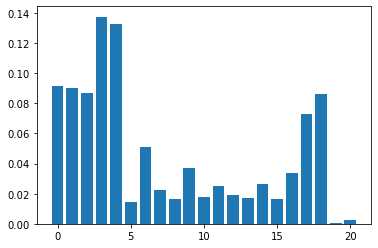

In [71]:
# Save the feature importances from the Random Forests classifier model to a variable named feature_importances
features = clf.feature_importances_
print(features)
plt.bar(x = range(len(features)), height=features)
plt.show()

In [72]:
# # Use the following code to plot the most important features
# features = sorted(zip(Xa.columns, features), key = lambda x: x[1])
# cols = [f[0] for f in features]
# width = [f[1] for f in features]

# fig, ax = plt.subplots()

# fig.set_size_inches(10,200)
# plt.margins(y=0.001)

# ax.barh(y=cols, width=width)

# plt.show()

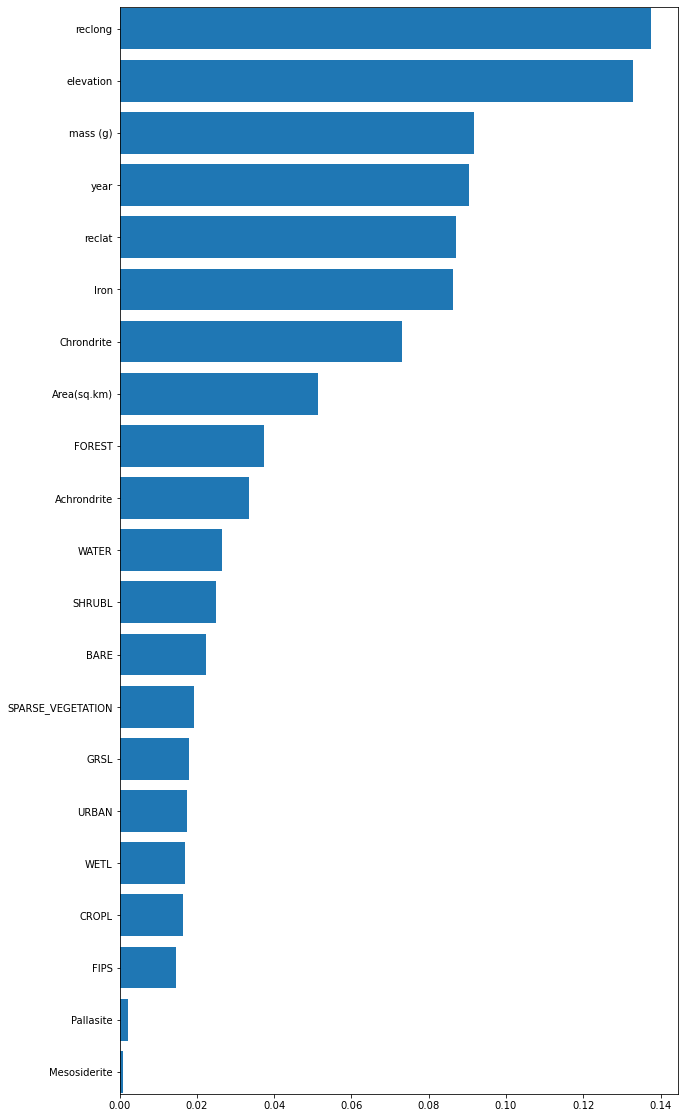

In [73]:
# Use the following code to plot the most important features
features = sorted(zip(X.columns, features), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(10,20)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()